# Week 4 - Data retrieval and dataset preprocessing

Before we utilize machine learning algorithms we must first obtain the data and prepare our dataset. This can often take a significant amount of time and can have a large impact on the performance of our models.

Data acquisition is an essential step of any data analysis and machine learning pipeline. There is a number of questions we can ask about the data:

* What type of data do we have?
* What are the data sources and how to retrieve data from these sources?
* Do we need to combine data from multiple sources?
* Is our data structured in such a way it can be used directly?
* Does our data need to be cleaned? Can our data be used directly in the analysis?
* What features have been used previously for similar tasks?
* Does our data require normalization and which one: Z-score normalization, min-max mormalization?

We will consider the following data sources:

* Files
* Web services
* Databases

We will be looking at four different types of data:

* Tabular data
* Image data
* Text


### Tabular data

We will look at three different steps we may need to take when handling tabular data: 

* Missing data
* Normalization
* Categorical data


### Image data

Image data can present a number of issues that we must address to maximize performance:

* Histogram normalization
* Windows
* Pyramids (for detection at different scales)
* Centering


### Text

Text can present a number of issues, mainly due to the number of words that can be found in our features. There are a number of ways we can convert from text to usable features:

* Bag of words
* Parsing

In [32]:
# required packages:
import numpy as np
import pandas as pd
import sklearn
import skimage
import sqlalchemy as sa

import urllib.request
import requests
import sys
import json
import pickle
import gzip
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

!pip install pymysql
import pymysql

# Data retrieval

## Files

Remote files can be downloaded directly from python. Depending on file format they can also be opened and read directly from python.

For python files are either text or binary, opened with 'b' binary mode. Python looks for line endings when reading text files: \n on Unix, \r\n on Windows.

open(file, 'rb')
open(file, 'wb')

Text files may be structured as tables (CSV). For more complex data structures other formats may be more appropriate:
* Images (binary)
* Archives as data containers (binary)
* HDF5 (binary)
* pickle (binary)
* JSON (text)
* XML (text)

Use appropriate python packages for operating data in these formats.

In [33]:
# An arbitrary collection of objects
data1 = {
    'a': [1, 2.0, 3, 4+6j],
    'b': ("character string", b"byte string"),
    'c': {None, True, False}
}
print(data1)

# write pickled data
with open('data.pickle', 'wb') as f:
    pickle.dump(data1, f)

# reads the resulting pickled data
with open('data.pickle', 'rb') as f:
    data2 = pickle.load(f)

print(data2)

{'b': ('character string', b'byte string'), 'a': [1, 2.0, 3, (4+6j)], 'c': {False, True, None}}
{'b': ('character string', b'byte string'), 'a': [1, 2.0, 3, (4+6j)], 'c': {False, True, None}}


In [34]:
data = {
    'a': [1, 2.0, 3],
    'b': ("character string", "string"),
    'c': [None, True, False]
}

print(data)
json_string = json.dumps(data)
new_data = json.loads(json_string)
print(new_data)

{'b': ('character string', 'string'), 'a': [1, 2.0, 3], 'c': [None, True, False]}
{'b': ['character string', 'string'], 'a': [1, 2.0, 3], 'c': [None, True, False]}


In [35]:
# Not all objects are supported by JSON
try:
    print(json.dumps(data1))
except TypeError as e:
    print(e)

b'byte string' is not JSON serializable


## Retrieving remote data

In [36]:
# Using urllib

ICGC_API = 'https://dcc.icgc.org/api/v1/download?fn=/release_18/Projects/BRCA-US/'
expression_fname = 'protein_expression.BRCA-US.tsv.gz'

if not Path(expression_fname).is_file():
    print("Downloading file", ICGC_API + expression_fname, "saving it as", expression_fname)
    urllib.request.urlretrieve(ICGC_API + expression_fname, expression_fname);
else:
    print("Local file exists:", expression_fname)

Local file exists: protein_expression.BRCA-US.tsv.gz


In [37]:
# Using requests

def get_genome_sequence_ensembl(chrom, start, end):
    """
    API described here http://rest.ensembl.org/documentation/info/sequence_region
    """
    url = 'https://rest.ensembl.org/sequence/region/human/{0}:{1}..{2}:1?content-type=application/json'.format(chrom, start, end)
    r = requests.get(url, headers={"Content-Type": "application/json"}, timeout=10.000)
    if not r.ok:
        print("REST Request FAILED")
        decoded = r.json()
        print(decoded['error'])
        return
    else:
        print("REST Request OK")
        decoded = r.json()
        return decoded['seq']

In [38]:
sequence = get_genome_sequence_ensembl(7, 200000,200100)
print(sequence)

REST Request OK
TTCTTGACACTGATTGATCTGCCAAAAGGGGAAGAATGAGTCCAGCTAGAATCCAGGACTAACCAGCGGGTGAGCTTCAAGGAACAAAGGGCTTCCGCTGG


In [39]:
# Reading data file
with gzip.open(expression_fname) as f:
    expression = f.read().decode('UTF-8')
    for i, line in enumerate(expression.split("\n")):
        if i == 0:
            continue
        if i > 3:
            break
        fields = line.split("\t")
        print(fields)

print()
# Loading data into numpy
E_np = np.genfromtxt(expression_fname, delimiter='\t', dtype=("|U10", "|U10", "|U10", float), 
                   skip_header=1, usecols=(0, 2, 7, 10))
print(E_np)

# Loading data into pandas
E_pd = pd.read_csv(expression_fname, delimiter='\t')
E_pd.head()

['DO4143', 'BRCA-US', 'SP8807', 'SA11426', 'TCGA-A1-A0SK-01A-21-A13A-20', '10694', 'PAI-1', 'SERPINE1', '', '', '1.76995355065757', 'not tested', '', 'M.D. Anderson Reverse Phase Protein Array Core', 'MDA_RPPA_Core http://tcga-data.nci.nih.gov/tcgafiles/ftp_auth/distro_ftpusers/anonymous/tumor/blca/cgcc/mdanderson.org/mda_rppa_core/protein_exp/mdanderson.org_BLCA.MDA_RPPA_Core.mage-tab.1.7.0/mdanderson.org_BLCA.MDA_RPPA_Core.idf.txt', 'TCGA', 'TCGA-A1-A0SK-01A-21-A13A-20']
['DO4143', 'BRCA-US', 'SP8807', 'SA11426', 'TCGA-A1-A0SK-01A-21-A13A-20', '10694', 'ARID1A', 'ARID1A', '', '', '0.619539316485755', 'not tested', '', 'M.D. Anderson Reverse Phase Protein Array Core', 'MDA_RPPA_Core http://tcga-data.nci.nih.gov/tcgafiles/ftp_auth/distro_ftpusers/anonymous/tumor/blca/cgcc/mdanderson.org/mda_rppa_core/protein_exp/mdanderson.org_BLCA.MDA_RPPA_Core.mage-tab.1.7.0/mdanderson.org_BLCA.MDA_RPPA_Core.idf.txt', 'TCGA', 'TCGA-A1-A0SK-01A-21-A13A-20']
['DO4143', 'BRCA-US', 'SP8807', 'SA11426', '

,icgc_donor_id,project_code,icgc_specimen_id,icgc_sample_id,submitted_sample_id,analysis_id,antibody_id,gene_name,gene_stable_id,gene_build_version,normalized_expression_level,verification_status,verification_platform,platform,experimental_protocol,raw_data_repository,raw_data_accession
0,DO4143,BRCA-US,SP8807,SA11426,TCGA-A1-A0SK-01A-21-A13A-20,10694,PAI-1,SERPINE1,NaN,NaN,1.769954,not tested,NaN,M.D. Anderson Reverse Phase Protein Array Core,MDA_RPPA_Core http://tcga-data.nci.nih.gov/tcg...,TCGA,TCGA-A1-A0SK-01A-21-A13A-20
1,DO4143,BRCA-US,SP8807,SA11426,TCGA-A1-A0SK-01A-21-A13A-20,10694,ARID1A,ARID1A,NaN,NaN,0.619539,not tested,NaN,M.D. Anderson Reverse Phase Protein Array Core,MDA_RPPA_Core http://tcga-data.nci.nih.gov/tcg...,TCGA,TCGA-A1-A0SK-01A-21-A13A-20
2,DO4143,BRCA-US,SP8807,SA11426,TCGA-A1-A0SK-01A-21-A13A-20,10694,mTOR_pS2448,FRAP1,NaN,NaN,-0.538637,not tested,NaN,M.D. Anderson Reverse Phase Protein Array Core,MDA_RPPA_Core http://tcga-data.nci.nih.gov/tcg...,TCGA,TCGA-A1-A0SK-01A-21-A13A-20
3,DO4143,BRCA-US,SP8807,SA11426,TCGA-A1-A0SK-01A-21-A13A-20,10694,ASNS,ASNS,NaN,NaN,1.156044,not tested,NaN,M.D. Anderson Reverse Phase Protein Array Core,MDA_RPPA_Core http://tcga-data.nci.nih.gov/tcg...,TCGA,TCGA-A1-A0SK-01A-21-A13A-20
4,DO4143,BRCA-US,SP8807,SA11426,TCGA-A1-A0SK-01A-21-A13A-20,10694,EGFR,EGFR,NaN,NaN,0.120138,not tested,NaN,M.D. Anderson Reverse Phase Protein Array Core,MDA_RPPA_Core http://tcga-data.nci.nih.gov/tcg...,TCGA,TCGA-A1-A0SK-01A-21-A13A-20


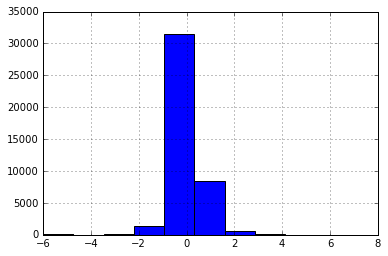

In [40]:
E_pd['normalized_expression_level'].hist()

## Connecting to a remote database server

SQL databases are convenient for storing and accessing data that requires concurrent access and control of integrity.

Example: UCSC Genomes database  http://genome.ucsc.edu/cgi-bin/hgTables

We use SQLAlchemy package and pymysql MySQL driver, which has the following major objects:
* Engine
* Connection
* Metadata
* Table

The typical usage of create_engine() is once per particular database URL, held globally for the lifetime of a single application process. A single Engine manages many individual DBAPI connections.  Here I am disabling connection pooling by Engine in order to use it in a Jupyter workbook.


In [41]:
engine = sa.create_engine('mysql+pymysql://genome@genome-mysql.cse.ucsc.edu/hg38', poolclass=sa.pool.NullPool)

The connection is an instance of Connection, which is a proxy object for an actual DBAPI connection. The DBAPI connection is retrieved from the connection pool at the point at which Connection is created.

In [42]:
connection = engine.connect()
result = connection.execute("SHOW TABLES")
for row in result:
    print("Table:", row[0])
connection.close()

# Connection supports context manager
with engine.connect() as connection:
    result = connection.execute("DESCRIBE refGene")
    for row in result:
        print("Columns:", row)

Table: affyGnf1h
Table: affyU133
Table: affyU95
Table: all_est
Table: all_mrna
Table: all_sts_primer
Table: all_sts_seq
Table: altLocations
Table: altSeqLiftOverPsl
Table: altSeqLiftOverPslP11
Table: altSeqLiftOverPslP3
Table: altSeqLiftOverPslP6
Table: augustusGene
Table: bigFiles
Table: bioCycMapDesc
Table: bioCycPathway
Table: ccdsGene
Table: ccdsInfo
Table: ccdsKgMap
Table: ccdsNotes
Table: ceBlastTab
Table: centromeres
Table: cgapAlias
Table: cgapBiocDesc
Table: cgapBiocPathway
Table: chainBosTau8
Table: chainBosTau8Link
Table: chainCanFam3
Table: chainCanFam3Link
Table: chainChlSab2
Table: chainChlSab2Link
Table: chainDanRer10
Table: chainDanRer10Link
Table: chainEquCab2
Table: chainEquCab2Link
Table: chainFelCat8
Table: chainFelCat8Link
Table: chainGalGal5
Table: chainGalGal5Link
Table: chainGalVar1
Table: chainGalVar1Link
Table: chainGorGor5
Table: chainGorGor5Link
Table: chainHg38Patch11
Table: chainHg38Patch11Link
Table: chainMacFas5
Table: chainMacFas5Link
Table: chainManPen

In [43]:
# Selected columns and rows using SQL
with engine.connect() as connection:
    result = connection.execute("""
        SELECT
            name, name2, chrom, strand, cdsStart, cdsEnd
        FROM
            refGene
        WHERE
            name2='ZNF107'
        """)
    for i, row in enumerate(result):
        print("Record #", i)
        print("\tGene {} ({})".format(row['name'], row['name2']))
        print("\tCDS location {} {}-{} on strand {}".format(row['chrom'], row['cdsStart'], row['cdsEnd'], row['strand']))

Record # 0
	Gene NM_016220 (ZNF107)
	CDS location chr7 64691941-64708656 on strand +
Record # 1
	Gene NM_001282360 (ZNF107)
	CDS location chr7 64666282-64708656 on strand +
Record # 2
	Gene NM_001282359 (ZNF107)
	CDS location chr7 64666282-64708656 on strand +
Record # 3
	Gene NR_104148 (ZNF107)
	CDS location chr7 64687830-64687830 on strand +
Record # 4
	Gene NR_104149 (ZNF107)
	CDS location chr7 64687830-64687830 on strand +
Record # 5
	Gene NM_001013746 (ZNF107)
	CDS location chr7 64691941-64708656 on strand +


In [44]:
meta = sa.MetaData(bind=engine)
meta.reflect(only=['refGene', 'snp147Common'])

# However, we need to modify metadata and add a primary key:
gene_table = sa.Table('refGene',
    meta,
    sa.PrimaryKeyConstraint('name'),
    extend_existing=True)

print(gene_table.columns.keys())
print(gene_table.c.strand.name, gene_table.c.strand.type)

['bin', 'name', 'chrom', 'strand', 'txStart', 'txEnd', 'cdsStart', 'cdsEnd', 'exonCount', 'exonStarts', 'exonEnds', 'score', 'name2', 'cdsStartStat', 'cdsEndStat', 'exonFrames']
strand CHAR(1)


### Pandas can read data directly from the database

In [45]:
snp_table = sa.Table('snp147Common',
    meta,
    sa.PrimaryKeyConstraint('name'),
    extend_existing=True)

# Getting data into pandas:
import pandas as pd

expr = sa.select([snp_table]).where(snp_table.c.chrom == 'chrY').limit(5)
pd.read_sql(expr, engine)

,bin,chrom,chromStart,chromEnd,name,score,strand,refNCBI,refUCSC,observed,...,locType,weight,exceptions,submitterCount,submitters,alleleFreqCount,alleles,alleleNs,alleleFreqs,bitfields
0,585,chrY,10020,10020,rs745593600,0,+,b'-',b'-',-/A/AAC,...,between,1,{MixedObserved},1,"b'1000GENOMES,'",3,"b'-,A,AAC,'","b'4906.000000,10.000000,92.000000,'","b'0.979633,0.001997,0.018371,'",{}
1,585,chrY,10034,10036,rs201278642,0,+,b'CC',b'CC',-/CC,...,range,1,{MixedObserved},2,"b'1000GENOMES,SSMP,'",2,"b'-,CC,'","b'369.000000,4637.000000,'","b'0.073711,0.926288,'",{maf-5-some-pop}
2,585,chrY,10051,10052,rs186434315,0,+,b'T',b'T',A/T,...,exact,1,{},2,"b'1000GENOMES,SSMP,'",2,"b'A,T,'","b'1582.000000,3426.000000,'","b'0.315895,0.684105,'","{maf-5-all-pops, maf-5-some-pop}"
3,585,chrY,10059,10060,rs148832940,0,+,b'G',b'G',C/G,...,exact,1,{},2,"b'1000GENOMES,WEILL_CORNELL_DGM,'",2,"b'C,G,'","b'245.000000,4763.000000,'","b'0.048922,0.951078,'",{maf-5-some-pop}
4,585,chrY,10068,10069,rs111065272,0,+,b'T',b'T',A/T,...,exact,1,{},4,"b'1000GENOMES,COMPLETE_GENOMICS,SSMP,WEILL_COR...",2,"b'A,T,'","b'1585.000000,3423.000000,'","b'0.316494,0.683506,'","{maf-5-all-pops, maf-5-some-pop}"


## Tabular data

* Missing data
* Normalization
* Categorical data

### Missing data

There are a number of ways to handle missing data:

* Drop all records with a value missing
* Substitute all missing values with an average value
* Substitute all missing values with some placeholder value, i.e. 0, 1e9, -1e9, etc
* Predict missing values based on other attributes
* Add additional feature indicating when a value is missing

If the machine learning model will be used with new data it is important to consider the possibility of receiving records with values missing that we have not observed previously in the training dataset.

The simplest approach is to remove any records that have missing data. Unfortunately missing values are often not randomly distributed through a dataset and removing them can introduce bias.

An alternative approach is to substitute the missing values. This can be with the mean of the feature across all the records or the value can be predicted based on the values of the other features in the dataset. Placeholder values can also be used with decision trees but do not work as well for most other algorithms.

Finally, missing values can themselves be useful features. Adding an additional feature indicating when a value is missing is often used to include this information. 

In [46]:
import sklearn.linear_model

x = np.array([[0, 0], [1, 1], [2, 2]])
y = np.array([0, 1, 2])
print(x,y)

clf = sklearn.linear_model.LinearRegression()
clf.fit(x, y)
print(clf.coef_)

x_missing = np.array([[0, 0], [1, np.nan], [2, 2]])
print(x_missing, y)

print()
try:
    clf = sklearn.linear_model.LinearRegression()
    clf.fit(x_missing, y)
    print(clf.coef_)
except ValueError as e:
    print(e)

[[0 0]
 [1 1]
 [2 2]] [0 1 2]
[ 0.5  0.5]
[[  0.   0.]
 [  1.  nan]
 [  2.   2.]] [0 1 2]

Input contains NaN, infinity or a value too large for dtype('float64').


In [47]:
x = pd.DataFrame([[0,1,2,3,4,5,6],
                  [2,np.nan,7,4,9,1,3],
                  [0.1,0.12,0.11,0.15,0.16,0.11,0.14],
                  [100,120,np.nan,127,130,121,124],
                  [4,1,7,9,0,2,np.nan]], ).T
x.columns = index=['A', 'B', 'C', 'D', 'E']

y = pd.Series([29.0,
 31.2,
 63.25,
 57.27,
 66.3,
 26.21,
 48.24])

print(x, y)

     A    B     C      D    E
0  0.0  2.0  0.10  100.0  4.0
1  1.0  NaN  0.12  120.0  1.0
2  2.0  7.0  0.11    NaN  7.0
3  3.0  4.0  0.15  127.0  9.0
4  4.0  9.0  0.16  130.0  0.0
5  5.0  1.0  0.11  121.0  2.0
6  6.0  3.0  0.14  124.0  NaN 0    29.00
1    31.20
2    63.25
3    57.27
4    66.30
5    26.21
6    48.24
dtype: float64


In [48]:
x1 = x.dropna()

In [49]:
x.fillna(value={'A':1000,'B':2000,'C':3000,'D':4000,'E':5000})

,A,B,C,D,E
0,0.0,2.0,0.10,100.0,4.0
1,1.0,2000.0,0.12,120.0,1.0
2,2.0,7.0,0.11,4000.0,7.0
3,3.0,4.0,0.15,127.0,9.0
4,4.0,9.0,0.16,130.0,0.0
5,5.0,1.0,0.11,121.0,2.0
6,6.0,3.0,0.14,124.0,5000.0


In [50]:
x.fillna(value=x.mean())

,A,B,C,D,E
0,0.0,2.000000,0.10,100.000000,4.000000
1,1.0,4.333333,0.12,120.000000,1.000000
2,2.0,7.000000,0.11,120.333333,7.000000
3,3.0,4.000000,0.15,127.000000,9.000000
4,4.0,9.000000,0.16,130.000000,0.000000
5,5.0,1.000000,0.11,121.000000,2.000000
6,6.0,3.000000,0.14,124.000000,3.833333


### Normalization

Many machine learning algorithms expect features to have similar distributions and scales.

A classic example is gradient descent, if features are on different scales some weights will update faster than others because the feature values scale the weight updates.

There are two common approaches to normalization:

* Z-score standardization
* Min-max scaling

#### Z-score standardization

Z-score standardization rescales values so that they have a mean of zero and a standard deviation of 1. Specifically we perform the following transformation:

$$z = \frac{x - \mu}{\sigma}$$

#### Min-max scaling

An alternative is min-max scaling that transforms data into the range of 0 to 1. Specifically:

$$x_{norm} = \frac{x - x_{min}}{x_{max} - x_{min}}$$

Min-max scaling is less commonly used but can be useful for image data and in some neural networks.

In [51]:
x_filled = x.fillna(value=x.mean())

print(x_filled)

     A         B     C           D         E
0  0.0  2.000000  0.10  100.000000  4.000000
1  1.0  4.333333  0.12  120.000000  1.000000
2  2.0  7.000000  0.11  120.333333  7.000000
3  3.0  4.000000  0.15  127.000000  9.000000
4  4.0  9.000000  0.16  130.000000  0.000000
5  5.0  1.000000  0.11  121.000000  2.000000
6  6.0  3.000000  0.14  124.000000  3.833333


In [52]:
x_norm = (x_filled - x_filled.min()) / (x_filled.max() - x_filled.min())

print(x_norm)

          A         B         C         D         E
0  0.000000  0.125000  0.000000  0.000000  0.444444
1  0.166667  0.416667  0.333333  0.666667  0.111111
2  0.333333  0.750000  0.166667  0.677778  0.777778
3  0.500000  0.375000  0.833333  0.900000  1.000000
4  0.666667  1.000000  1.000000  1.000000  0.000000
5  0.833333  0.000000  0.166667  0.700000  0.222222
6  1.000000  0.250000  0.666667  0.800000  0.425926


In [53]:
scaling = sklearn.preprocessing.MinMaxScaler().fit(x_filled)
scaling.transform(x_filled)

array([[ 0.        ,  0.125     ,  0.        ,  0.        ,  0.44444444],
       [ 0.16666667,  0.41666667,  0.33333333,  0.66666667,  0.11111111],
       [ 0.33333333,  0.75      ,  0.16666667,  0.67777778,  0.77777778],
       [ 0.5       ,  0.375     ,  0.83333333,  0.9       ,  1.        ],
       [ 0.66666667,  1.        ,  1.        ,  1.        ,  0.        ],
       [ 0.83333333,  0.        ,  0.16666667,  0.7       ,  0.22222222],
       [ 1.        ,  0.25      ,  0.66666667,  0.8       ,  0.42592593]])

### Categorical data

Categorical data can take one of a number of possible values. The different categories may be related to each other or be largely independent and unordered.

Continuous variables can be converted to categorical variables by applying a threshold.

In [54]:
x = pd.DataFrame([[0,1,2,3,4,5,6],
                  [2,np.nan,7,4,9,1,3],
                  [0.1,0.12,0.11,0.15,0.16,0.11,0.14],
                  [100,120,np.nan,127,130,121,124],
                  ['Green','Red','Blue','Blue','Green','Red','Green']], ).T
x.columns = ['A', 'B', 'C', 'D', 'E']

print(x)

   A    B     C    D      E
0  0    2   0.1  100  Green
1  1  NaN  0.12  120    Red
2  2    7  0.11  NaN   Blue
3  3    4  0.15  127   Blue
4  4    9  0.16  130  Green
5  5    1  0.11  121    Red
6  6    3  0.14  124  Green


In [55]:
x_cat = x.copy()

for val in x['E'].unique():
    x_cat['E_{0}'.format(val)] = x_cat['E'] == val

x_cat

,A,B,C,D,E,E_Green,E_Red,E_Blue
0,0,2,0.1,100,Green,True,False,False
1,1,NaN,0.12,120,Red,False,True,False
2,2,7,0.11,NaN,Blue,False,False,True
3,3,4,0.15,127,Blue,False,False,True
4,4,9,0.16,130,Green,True,False,False
5,5,1,0.11,121,Red,False,True,False
6,6,3,0.14,124,Green,True,False,False


## Image data

Depending on the type of task being performed there are a variety of steps we may want to take in working with images:

* Histogram normalization
* Windows and pyramids (for detection at different scales)
* Centering

Occasionally the camera used to generate an image will use 10- to 14-bits while a 16-bit file format will be used. In this situation all the pixel intensities will be in the lower values. Rescaling to the full range (or to 0-1) can be useful.

Further processing can be done to alter the histogram of the image.


When looking for particular features in an image a sliding window can be used to check different locations. This can be combined with an image pyramid to detect features at different scales. This is often needed when objects can be at different distances from the camera.

If objects are sparsely distributed in an image a faster approach than using sliding windows is to identify objects with a simple threshold and then test only the bounding boxes containing objects. Before running these through a model centering based on intensity can be a useful approach. Small offsets, rotations and skewing can be used to generate additional training data.

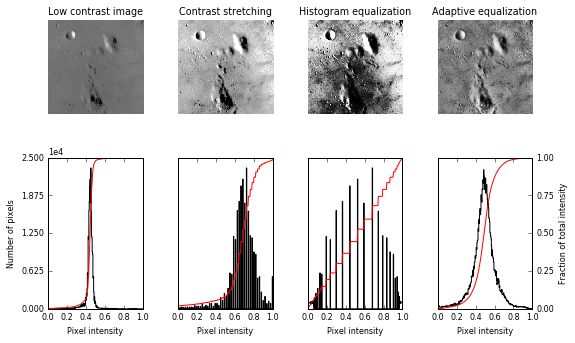

In [56]:
# http://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_equalize.html#example-color-exposure-plot-equalize-py
matplotlib.rcParams['font.size'] = 8

import skimage.data

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

def plot_img_and_hist(img, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    img = skimage.img_as_float(img)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(img, cmap=plt.cm.gray)
    ax_img.set_axis_off()
    ax_img.set_adjustable('box-forced')

    # Display histogram
    ax_hist.hist(img.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = skimage.exposure.cumulative_distribution(img, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
img = skimage.data.moon()

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = skimage.exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = skimage.exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = skimage.exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2,4), dtype=np.object)
axes[0,0] = fig.add_subplot(2, 4, 1)
for i in range(1,4):
    axes[0,i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0,4):
    axes[1,i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

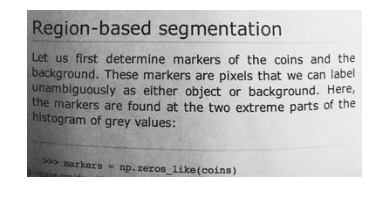

(191, 384)


In [57]:
img = skimage.data.page()
fig, ax = plt.subplots(1,1)
ax.imshow(img, cmap=plt.cm.gray)
ax.set_axis_off()
plt.show()
print(img.shape)

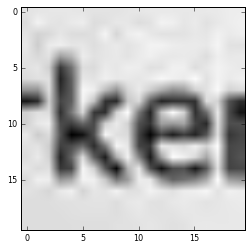

In [58]:
import sklearn.feature_extraction

patches = sklearn.feature_extraction.image.extract_patches_2d(img, (20, 20), max_patches=2, random_state=0)
patches.shape
plt.imshow(patches[0], cmap=plt.cm.gray)
plt.show()

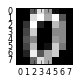

In [59]:
import sklearn.datasets

digits = sklearn.datasets.load_digits()
# print(digits.DESCR)
fig, ax = plt.subplots(1,1, figsize=(1,1))
ax.imshow(digits.data[0].reshape((8,8)), cmap=plt.cm.gray, interpolation='nearest')

## Text

When working with text the simplest approach is known as bag of words. In this approach we simply count the number of instances of each word, and then adjust the values based on how commonly the word is used.

The first task is to break a piece of text up into individual tokens. The number of occurrences of each word is then recorded. More rarely used words are likely to be more interesting and so word counts are scaled by the inverse document frequency.

We can extend this to look at not just individual words but also bigrams and trigrams.

In [60]:
twenty_train = sklearn.datasets.fetch_20newsgroups(subset='train',
    categories=['comp.graphics', 'sci.med'], shuffle=True, random_state=0)

print(twenty_train.target_names)

count_vect = sklearn.feature_extraction.text.CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)
print(X_train_counts.shape)

tfidf_transformer = sklearn.feature_extraction.text.TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# print(X_train_tfidf.shape, X_train_tfidf[:5,:15].toarray())

['comp.graphics', 'sci.med']
(1178, 24614)


In [61]:
print(twenty_train.data[0])

From: harti@mikro.ee.tu-berlin.de (Stefan Hartmann (Behse))
Subject: Genoa graphics board Drivers FTP site!
Article-I.D.: mailgzrz.1qpf1r$9ti
Organization: TUBerlin/ZRZ
Lines: 29
NNTP-Posting-Host: mikro.ee.tu-berlin.de

Hi,

well I have opened up a FTP site for getting the latest software drivers
for Genoa graphics cards.

Here is how to access it:

ftp 192.109.42.11
login:ftp
password:ftp
cd pub/genoa
ls -l
binary
prompt
hash

(now if you wanna have the latest drivers for the 7900 board)

cd 7000series
mget *

quit

This is the sequence to get the drivers.

If you have any further question, please email me.

Best regards, Stefan Hartmann
email to: harti@mikro.ee.tu-berlin.de



In [62]:
count_vect = sklearn.feature_extraction.text.CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data[0:1])
print(X_train_counts[0].toarray())
print(count_vect.vocabulary_.keys())


[[1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 2 1 2 3 4 3 2 3 1 5 1 3 1 1 2 2 2 1 3 1 1
  1 1 2 2 1 2 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 5 1 3 3 1 1 1
  1 2 1]]
dict_keys(['this', 'mailgzrz', 'stefan', 'cards', 'regards', 'to', 'ftp', 'pub', 'password', 'now', 'lines', 'posting', 'site', 'software', 'from', 'ee', 'please', '192', 'de', 'nntp', 'prompt', 'subject', 'login', 'wanna', 'quit', '9ti', 'drivers', 'cd', 'up', 'is', '109', 'binary', '7900', 'for', 'have', 'zrz', 'behse', 'berlin', 'well', '42', 'board', '1qpf1r', 'organization', 'ls', 'me', 'mikro', 'tu', 'harti', 'the', 'if', 'host', 'sequence', 'opened', 'tuberlin', 'you', '29', 'further', 'here', 'get', '7000series', 'how', 'article', 'hi', 'any', 'hartmann', 'email', 'access', 'best', 'getting', 'latest', 'it', 'graphics', 'genoa', 'mget', '11', 'hash', 'question'])
